# Задание 1 (5 балла)

Имплементируйте алгоритм Леска (описание есть в семинаре) и оцените качество его работы на датасете `data/corpus_wsd_50k.txt`

В качестве метрики близости вы должны попробовать два подхода:

1) Jaccard score на множествах слов (определений и контекста)
2) Cosine distance на эмбедингах sentence_transformers

В качестве метрики используйте accuracy (% правильных ответов). Предсказывайте только многозначные слова в датасете

Контекст вы можете определить самостоятельно (окно вокруг целевого слова или все предложение). Также можете поэкспериментировать с предобработкой для обоих методов.

In [ ]:
!pip install sentence-transformers nltk scikit-learn
import nltk
nltk.download('punkt')
nltk.download("wordnet")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
 !python -m pip install torch torchvision torchaudio
 !python -m pip install sentence_transformers transformers accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 99.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1
  Attempting uninstall: sentence_transformers
    Found existing installation: sentence-transformers 5.1.0
    Uninstalling sentence-transformers-5.1.0:
      Successfully uninstalled sentence-transformers-5.1.0


In [ ]:
!mkdir data
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/corpus_wsd_50k.txt.zip -P data
!unzip -o data/corpus_wsd_50k.txt.zip -d data/

--2025-10-01 15:33:27--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/corpus_wsd_50k.txt.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/corpus_wsd_50k.txt.zip [following]
--2025-10-01 15:33:28--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/corpus_wsd_50k.txt.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4723095 (4.5M) [application/zip]
Saving to: ‘data/corpus_wsd_50k.txt.zip’

corpus_wsd_50k.txt. 100%[===================>]   4.50M  --.-KB/s    in 0.05s   

2025-10-01 15:33:28 (

In [ ]:
corpus_wsd = []
corpus = open('data/corpus_wsd_50k.txt').read().split('\n\n')
for sent in corpus:
    corpus_wsd.append([s.split('\t') for s in sent.split('\n')])

In [ ]:
import re
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import wordnet as wn
from nltk import word_tokenize

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embed = model.encode

def preprocess_text(text):
  text = text.lower()
  text = re.sub(r"[^a-z0-9\s]+", "", text)
  return text

def get_context_window(text, target_word, window_size = 3):
    words = word_tokenize(text)
    if target_word not in words:
        print('Target word отсутствует')
    target_index = words.index(target_word)
    start = max(0, target_index - window_size)
    end = min(len(words), target_index + window_size + 1)
    context = words[start:target_index] + words[target_index+1:end]
    return ' '.join(context)

def jaccard_func(definition, context):
    intersection = set(definition.split()) & set(context.split())
    union = set(definition.split()) | set(context.split())
    return len(intersection) / len(union) if union else 0

def cosine_sim(definition, context):
  definition_emb = embed([definition])[0].reshape(1, -1)
  context_emb = embed([context])[0].reshape(1, -1)
  return cosine_similarity(context_emb, definition_emb)[0][0]

def get_definitions(word, lemma, tag):
    definitions = []
    if tag:  # если в корпусе есть sense key
      synset = wn.lemma_from_key(tag).synset()
      definitions.append((synset.definition(), synset.name()))
    else:  # однозначное слово → берём первый синсет
      synsets = wn.synsets(lemma)
      if synsets:
        for s in synsets:
          definitions.append((s.definition(), s.name()))
    return definitions

def lesk_algorithm(text, word, lemma=None, tag=None, method="jaccard_func"):
    context = get_context_window(text, word)
    cleaned_context = preprocess_text(context)
    definitions = get_definitions(word, lemma or word, tag)
    best_definition, best_score, best_synset = None, -1, None

    for definition, syn_id in definitions:
        definition_clean = preprocess_text(definition)

        if method == "jaccard":
            score = jaccard_func(definition_clean, cleaned_context)
        elif method == "cosine":
            score = cosine_sim(definition_clean, cleaned_context)
        else:
          print('Пока! Ты не выбрал метрику')

        if score > best_score:
            best_score = score
            best_definition = definition
            best_synset = syn_id

    return best_definition, best_synset, best_score


def accuracy_score(data, definitions, method="cosine_sim"):
    correct = 0
    total = len(data)

    for text, word, lemma, tag, gold in data:
        predicted_def, synset_id, score = lesk_algorithm(text, word, lemma, tag, method)
        if synset_id == gold:
            correct += 1

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
text = "I like my computer mouse"
word = "mouse"

definition, syn_id, score = lesk_algorithm(text, word, method="cosine")
print("Лучшее значение:", definition)
print("ID синсета:", syn_id)
print("Сходство:", score)

Лучшее значение: manipulate the mouse of a computer
ID синсета: mouse.v.02
Сходство: 0.37061596


In [ ]:
text = "Cat ate this little mouse"
word = "mouse"

definition, syn_id, score = lesk_algorithm(text, word, method="jaccard")

print("Лучшее значение:", definition)
print("ID синсета:", syn_id)
print("Сходство:", score)

Лучшее значение: any of numerous small rodents typically resembling diminutive rats having pointed snouts and small ears on elongated bodies with slender usually hairless tails
ID синсета: mouse.n.01
Сходство: 0.0


# Задание 2 (5 балла)
Попробуйте разные алгоритмы кластеризации на датасете - `https://github.com/nlpub/russe-wsi-kit/blob/initial/data/main/wiki-wiki/train.csv`

Используйте код из семинара как основу. Используйте ARI как метрику качества.

Попробуйте все 4 алгоритма кластеризации, про которые говорилось на семинаре. Для каждого из алгоритмов попробуйте настраивать гиперпараметры (посмотрите их в документации). Прогоните как минимум 5 экспериментов (не обязательно успешных) с разными параметрами на каждый алгоритме кластеризации и оцените: качество кластеризации, скорость работы, интуитивность параметров.

Помимо этого также выберите 1 дополнительный алгоритм кластеризации отсюда - https://scikit-learn.org/stable/modules/clustering.html , опишите своими словами принцип его работы  и проделайте аналогичные эксперименты.

In [ ]:

from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, SpectralClustering
import numpy as np
from sklearn.metrics import adjusted_rand_score
import pandas as pd
from IPython.display import Image
from IPython.core.display import HTML
import time

In [4]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embed = model.encode

df = pd.read_csv('https://raw.githubusercontent.com/nlpub/russe-wsi-kit/initial/data/main/wiki-wiki/train.csv', sep='\t')
grouped_df = df.groupby('word')[['word', 'context', 'gold_sense_id']]

def run_experiment(algorithm, params):
    ARI = []
    start = time.time()
    for key, _ in grouped_df:
        texts = grouped_df.get_group(key)["context"].values
        gold = grouped_df.get_group(key)["gold_sense_id"].values
        X = np.zeros((len(texts), embedding_dim))
        for i, text in enumerate(texts):
            X[i] = embed(text)

        cluster = algorithm(**params)
        labels = cluster.fit_predict(X)

        ARI.append(adjusted_rand_score(gold, labels))
    return np.mean(ARI), time.time() - start

experiments = {
    "KMeans": [
        {"n_clusters": 2, "init": "k-means++", "random_state": 42},
        {"n_clusters": 3, "init": "random", "random_state": 42},
        {"n_clusters": 5, "n_init": 10},
        {"n_clusters": 2, "max_iter": 50},
        {"n_clusters": 2, "max_iter": 500}
    ],
    "DBSCAN": [
        {"eps": 0.3, "min_samples": 2, "metric": "cosine"},
        {"eps": 0.5, "min_samples": 5, "metric": "cosine"},
        {"eps": 1.0, "min_samples": 3},
        {"eps": 0.7, "min_samples": 10},
        {"eps": 0.2, "min_samples": 1}
    ],
    "Agglomerative": [
        {"n_clusters": 2, "linkage": "ward"},
        {"n_clusters": 3, "linkage": "average"},
        {"n_clusters": 4, "linkage": "complete"},
        {"n_clusters": 2, "linkage": "average"},
        {"n_clusters": 2, "linkage": "single"}
    ],
    "AffinityPropagation": [
        {"damping": 0.5, "random_state": 42},
        {"damping": 0.7, "random_state": 42},
        {"damping": 0.9, "random_state": 42},
        {"preference": -50, "random_state": 42},
        {"preference": -100, "random_state": 42}
    ],
    "Spectral": [
        {"n_clusters": 2, "assign_labels": "discretize", "random_state": 42},
        {"n_clusters": 3, "assign_labels": "kmeans", "random_state": 42},
        {"n_clusters": 4, "assign_labels": "discretize", "random_state": 42},
        {"n_clusters": 2, "affinity": "nearest_neighbors", "random_state": 42},
        {"n_clusters": 2, "affinity": "rbf", "gamma": 1.0, "random_state": 42}
    ]
}

results = []
for algo_name, param_list in experiments.items():
    for params in param_list:
        try:
            score, elapsed = run_experiment(algorithms[algo_name], params)
            results.append((algo_name, str(params), round(score, 4), round(elapsed, 2)))
        except Exception as e:
            results.append((algo_name, str(params), None, f"ERROR: {e}"))



results_df = pd.DataFrame(results, columns=["Algorithm", "Params" ,"ARI", "Time (s)"])
print(results_df)

/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_affinity_propagation.py:162: ConvergenceWarning: Affinity propagation did not converge and this model will not have any cluster centers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_affinity_propagation.py:162: ConvergenceWarning: Affinity propa

              Algorithm                                             Params  \
0                KMeans  {'n_clusters': 2, 'init': 'k-means++', 'random...   
1                KMeans  {'n_clusters': 3, 'init': 'random', 'random_st...   
2                KMeans                    {'n_clusters': 5, 'n_init': 10}   
3                KMeans                  {'n_clusters': 2, 'max_iter': 50}   
4                KMeans                 {'n_clusters': 2, 'max_iter': 500}   
5                DBSCAN  {'eps': 0.3, 'min_samples': 2, 'metric': 'cosi...   
6                DBSCAN  {'eps': 0.5, 'min_samples': 5, 'metric': 'cosi...   
7                DBSCAN                     {'eps': 1.0, 'min_samples': 3}   
8                DBSCAN                    {'eps': 0.7, 'min_samples': 10}   
9                DBSCAN                     {'eps': 0.2, 'min_samples': 1}   
10        Agglomerative               {'n_clusters': 2, 'linkage': 'ward'}   
11        Agglomerative            {'n_clusters': 3, 'linkage': 

Эскперименты:
- все результаты низкие, возможно дело в том, что нужно ещё больше копаться в параметрах(?)
- максимальные результаты:

```
Agglomerative (n_clusters=2) → 0.0535 (лучший результат).
Spectral (3, kmeans) → 0.0465.
KMeans (3, random) → 0.0463.
AffinityPropagation (damping 0.5–0.7) → 0.0423.
AffinityPropagation кидает ошибки - возможно при смене параметров будут лучшие результаты
```

- время: overall все уложились +-3 секунды


```
самые быстрые KMeans, DBSKAN
```


- интуитивность параметров:


```
самый понятный - KMeans, параметры легко управляются
Остальные непонятны интуитивно, особенно дополнительный метод со спектрами, с ними долго мучалась, но результатов особых это не принесло (как видно)
В общем, понятны параметры, связанные с числом предполагаемых кластеров, а с остальным надо долго методом тыка работать
```





**SpectralClustering**


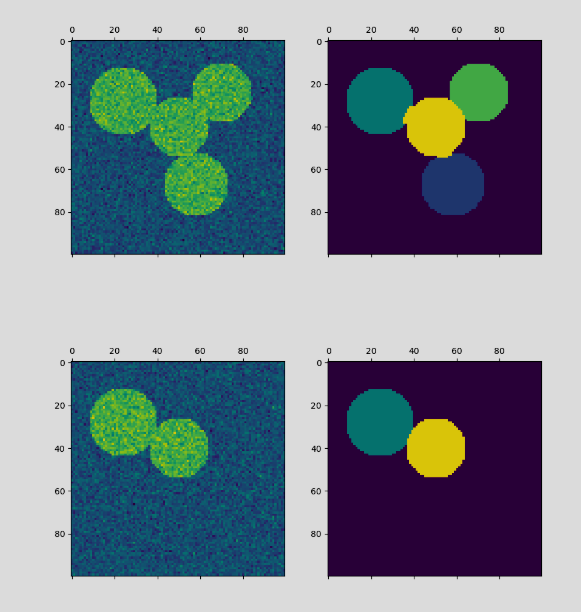

В чем суть метода?
Берутся все объекты, потом считается, насколько они близки и получается матрица сходства, а потом она подается на вход и считаются её собственные векторы, а потом используется KMeans на вот этом спектре